# Kinetics Project Validation Tool
## This notebook can be used to validate a model against experimental data
The following is the isothermal reaction under investigation:
$\require{mhchem}$
$$\ce{A ->[C] D + U}$$

where A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.
We can control the starting concentration of A, the concentration of C, and the reaction temperature.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import linregress
%matplotlib inline

## Use the following cell to import tab-separated experiment data

In [2]:
filename = "data/exp1428.tsv"
exp = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['Time', 'A', 'D', 'U'])
init = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=1, names=['A', 'D', 'U', 'C', 'T'], nrows=1, usecols=range(2, 7))
t_final = exp.Time.values[-1]
t_prefinal = exp.Time.values[-2]

## We propose the following mechanism
$\require{mhchem}$
$$\ce{\alpha A <=>[k_1][k_{-1}] \beta_1 B}$$

$$\ce{\beta_2 B + \gamma C ->[k_2] \delta D + \gamma C}$$

$$\ce{\beta_3 B ->[k_3] \upsilon U}$$

A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.

The following rate laws will be tested.

$$-r_A = k_1 C_A^{\alpha} - k_{-1} C_B^{\beta_1}$$

$$r_D = k_2 C_B^{\beta_2} C_C^{\gamma}$$

$$r_U = k_3 C_B^{\beta_3}$$

$$r_B = -r_A - r_D - r_U$$

## Use the cell below to enter a rate law. Define all necessary constants

In [3]:
def dadt(cA, cB, alpha, beta1, k1, k_1):
    return k_1 * cB**beta1 - k1 * cA**alpha
    
def dudt(cB, beta3, k3):
    return k3 * cB**beta3

def dddt(cB, cC, beta2, gamma, k2):
    return k2 * cB**beta2 * cC**gamma

def concentrations(cA0, cC0, T, time, params):
    """"
    This function calculates the concentrations of the reacting species using a proposed rate law
    cA (mol/L) is the initial concentration of reactant A
    cC (mol/L) is the initial catalyst concentration
    T (K) is the temperature
    time (s) is the elapsed reaction time
    Return values:
    time (s) array of times at which concentrations were calculated
    cA (mol/L) array of concentrations of A during the time interval
    cD (mol/L) array of concentrations of the desired product D during the time interval
    cU (mol/L) array of concentrations of the undesired product U during the time interval
    """
    
    try:
        alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3 = params
    except:
        print("Params should contain at least 9 parameters!")
        return -1, -1, -1, -1,
    else:                
        def rates(parms, time):
            """
            Returns the RHS of the system of ODEs
            """
            C_A, C_B, C_D, C_U = parms
            rateD = dddt(C_B, cC0, beta2, k1, k_1)
            rateU = dudt(C_B, beta3, k3)
            rateA = dadt(C_A, C_B, alpha, beta1, k1, k_1)
            rateB = -1 * rateA - rateD - rateU
            return (rateA, rateB, rateD, rateU)
        
        times = np.linspace(0, time, 100)
        
        result = odeint(rates, (cA0, 0., 0., 0.), times)
        
        cA = result[:,0]
        cB = result[:,1]
        cD = result[:,2]
        cU = result[:,3]
        
    return times, cA, cD, cU, cB

## Integrate
Use the cell below to carry out the integration

In [4]:
alpha = 2. # 3
beta1 = 2. # 2
beta2 = 2. # 2
beta3 = 2.2 # 2
gamma = 1. # 1
k1 = 4. # 2.2
k_1 = 1.5 # 1.6
k2 = 1. # 1
k3 = 0.647 # 0.38
times, A, D, U, B = concentrations(init.A, init.C, init.T, t_prefinal,
                                (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3))

## Plot
Plot the results of the calculation.

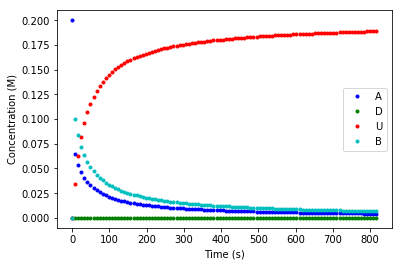

In [13]:
plt.plot(times, A, 'b.', label='A')
plt.plot(times, D, 'g.', label='D')
plt.plot(times, U, 'r.', label='U')
plt.plot(times, B, 'c.', label='B')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()

## Compare
Compare to the experimental results below.

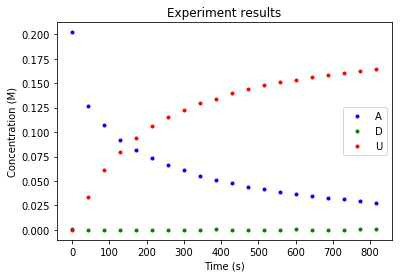

In [18]:
plt.plot(exp.Time.values[:-1], exp.A.values[:-1], 'b.', label='A')
plt.plot(exp.Time.values[:-1], exp.D.values[:-1], 'g.', label='D')
plt.plot(exp.Time.values[:-1], exp.U.values[:-1], 'r.', label='U')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.title('Experiment results')
plt.show()

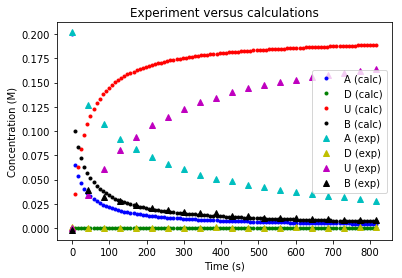

In [22]:
exp_possible_b = init.A.values[0] - (exp.A.values + exp.U.values) # mol/L of A unaccounted for (potential B)
# Plot experimental and calculated results on the same chart
plt.plot(times, A, 'b.', label='A (calc)')
plt.plot(times, D, 'g.', label='D (calc)')
plt.plot(times, U, 'r.', label='U (calc)')
plt.plot(times, B, 'k.', label='B (calc)')
plt.plot(exp.Time.values[:-1], exp.A.values[:-1], 'c^', label='A (exp)')
plt.plot(exp.Time.values[:-1], exp.D.values[:-1], 'y^', label='D (exp)')
plt.plot(exp.Time.values[:-1], exp.U.values[:-1], 'm^', label='U (exp)')
plt.plot(exp.Time.values[:-1], exp_possible_b[:-1], 'k^', label='B (exp)')
plt.legend()
plt.title('Experiment versus calculations')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.show()

## Obtaining rates from experimental data

In [23]:
# 3-point differentiation of experimental [A] and [U]
exp_a = exp.A.values[:-1] # ignore the last long-time value
exp_u = exp.U.values[:-1] # ignore the last long-time value
exp_t = exp.Time.values[:-1] # ignore the last long-time value
exp_missing_a = init.A.values[0] - (exp_a + exp_u) # mol/L of A unaccounted for (potential B)
delta_t = exp_t[1] - exp_t[0]
exp_ra = (np.diff(exp_a[:-1]) + np.diff(exp_a[1:])) / (2 * delta_t)
exp_ru = (np.diff(exp_u[:-1]) + np.diff(exp_u[1:])) / (2 * delta_t)

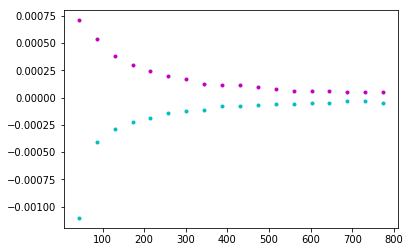

In [24]:
# Plot of dudt, dadt vs time
plt.plot(exp_t[1:-1], exp_ru, 'm.', exp_t[1:-1], exp_ra, 'c.')

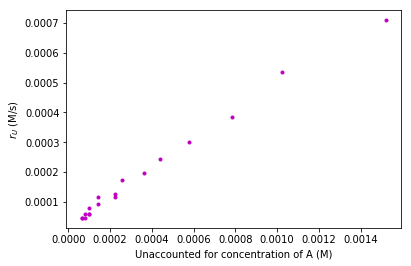

In [25]:
# Plot of du/dt against (missing_a)^2 (looks linear)
plt.plot(exp_missing_a[1:-1]**2, exp_ru, 'm.')
plt.xlabel('Unaccounted for concentration of A (M)')
plt.ylabel('$r_U$ (M/s)')

The above plot implies that $\beta_3 = 2$.

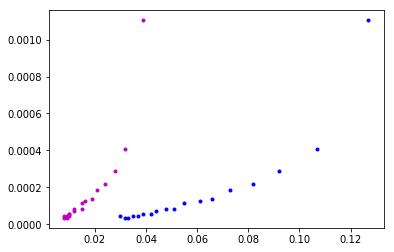

In [26]:
# Plot of -(da/dt) against the concentrations of A and B
plt.plot(exp_a[1:-1], -1.*exp_ra, 'b.',
        exp_missing_a[1:-1], -1.*exp_ra, 'm.')

## Optimization of $k_3$ based no-catalyst data

In [27]:
def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))

In [28]:
x_data = exp_missing_a[1:-1]
y_data = exp_ru

beta3_trial = 2.2
def dudt_partial(cB, k3_opt):
    return dudt(cB, beta3_trial, k3_opt)

popt, pcov = curve_fit(dudt_partial, x_data, y_data)

optimal_parameters = popt
parameter_errors = np.sqrt(np.diag(pcov))

report(popt, pcov)

Parameter 0: 0.9895006524193831 +/- 0.03465126241952464 (1 st. dev.)


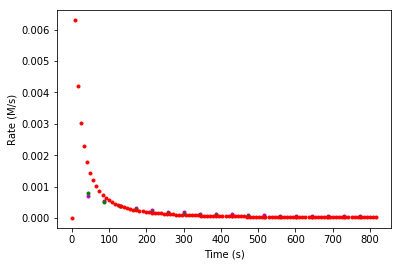

In [30]:
calc_ru_sparse = dudt(x_data, beta3_trial, popt[0])
calc_ru = dudt(B, beta3_trial, popt[0])

# Plot of du/dt obtained from experimental data and calculated du/dt versus time
#plt.plot(exp_t[1:-1], exp_ru, 'm.',
#        exp_t[1:-1], calc_ru, 'r.')
plt.plot(exp_t[1:-1], exp_ru, 'm.',
         exp_t[1:-1], calc_ru_sparse, 'g.',
        times, calc_ru, 'r.')
plt.xlabel('Time (s)')
plt.ylabel('Rate (M/s)')

k3 =  0.205622853885 
beta3=  1.744630342


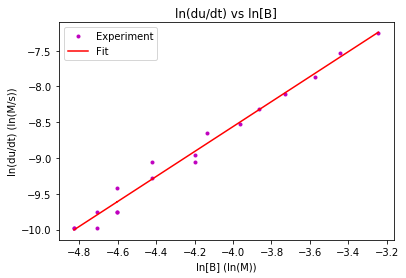

In [35]:
# Plot of ln(du/dt) vs ln([B]) for experimental and calculated data
#plt.plot(np.log(exp_missing_a[1:-1]), np.log(exp_ru), 'm.',
#        np.log(B), np.log(calc_ru), 'r.')
lnB = np.log(exp_missing_a[1:-1])
lnru_exp = np.log(exp_ru)
beta3_fit, lnk3_fit, r_val, p_val, std_err = linregress(lnB, lnru_exp)
plt.plot(lnB, lnru_exp, 'm.', label='Experiment')
plt.plot(lnB, lnk3_fit + beta3_fit * lnB, 'r-', label='Fit')
plt.legend()
plt.title('ln(du/dt) vs ln[B]')
plt.xlabel('ln[B] (ln(M))')
plt.ylabel('ln(du/dt) (ln(M/s))')
print('k3 = ', np.exp(lnk3_fit), '\nbeta3= ', beta3_fit)